In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

### Lataa kuvadatat TensorFlowin image_dataset_from_directory-funktiolla.
- Kuvaa ladataan kolmesta kansiosta: 
    - Koulutusdata: kuvat/train kansiosta
    - Validointidata: kuvat/validation_ kansiosta
    - Testdata: kuvat/test kansiosta
- Kaikki kuvat muunnetaan kokoon 224x224 pikseliä.
- 4 kuvaa trainissa, 2 kuvaa validaoinnnissa ja  testissä käsitellään kerrallaan mallin syötteessä.

In [2]:
num_classes = 3
# Load datasets
train_dataset = image_dataset_from_directory(
    os.path.join("kuvat/train"),
    image_size=(224, 224),
    batch_size=4
)
validation_dataset = image_dataset_from_directory(
    os.path.join("kuvat/validation"),
    image_size=(224, 224),
    batch_size=2
)
test_dataset = image_dataset_from_directory(
    os.path.join("kuvat/test"),
    image_size=(224, 224),
    batch_size=2
)

Found 126 files belonging to 3 classes.
Found 27 files belonging to 3 classes.
Found 27 files belonging to 3 classes.


Määritellään, että on 3 eri luokkaa (lusikka, haarukka ja veitsi).

luodaan datan augmentointiputki vain train_datasetille:

- RandomFlip("horizontal")
    - Kääntää kuvan vaakasuunnassa satunnaisesti.

- RandomRotation(0.1)
    - Pyöräyttää kuvaa ±10 % (eli n. ±36 astetta) satunnaisesti.

- RandomZoom(0.2)

In [3]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
    ]
)

# Apply augmentation only to the training dataset.
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))


Ladataan valmiiksi opetettu VGG16 ilman ylintä (dense) osaa
- clude_top=False: Poistetaan alkuperäinen luokittelupää
- conv_base.trainable = False
    - Tämä jäädyttää VGG16:n painot, eli:
    
    - Ei päivitetä näitä kerroksia koulutuksessa.
    
    - Toimivat pelkkänä valmiina piirteiden tunnistimena.

In [4]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

1. Syötekerros:
- Inputs: Määritetään mallin syötekuvan koko: 224x224 ja 3 värikanavaa (RGB).
2. Esiprosessointi:
- VGG16-malli vaatii tietyntyyppistä esiprosessointia:
    - Pikselit muutetaan oikeaan mittakaavaan.
    - Vähennetään keskiarvot ([103.939, 116.779, 123.68])    
    - Muutetaan BGR-järjestykseen
3. VGG16 ilman ylintä osaa:
    - Käytetään aiemmin ladattua ja jäädytettyä conv_base-verkkoa.
4. Omien kerros lisääminen:
    - Flatten → muutetaan piirrejoukko vektoriksi
    - Dense (256) → opetettava, täysin yhdistetty kerros   
    - Dropout (0.5) → ehkäistään ylisovittamista    
    - Dense (num_classes) → lopullinen softmax-luokituskerros
5. Koko mallin rakentaminen
    - Sidotaan syöte ja lähtö yhteen keras.Model-olioon.
6. Käännös (compile)
    - Käytetään sparse_categorical_crossentropy, koska luokat ovat kokonaislukuja, ei one-hot vektoreita.

In [5]:
inputs = keras.Input(shape=(224, 224, 3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)  

model = keras.Model(inputs, outputs)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ input_layer_2[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ input_layer_2[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 25088)     │          0 │ vgg16[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  6,422,784 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 3)         │        771 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 21,138,243 (80.64 MB)

 Trainable params: 6,423,555 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

lisää ModelCheckpoint-callbackin, joka tallentaa parhaan version mallista koulutuksen aikana.
- filepath="feature_extraction.keras": Mihin tiedostoon malli tallennetaan.
- onitor="val_loss": Seuraa validointihäviötä.

In [6]:
callbacks = [
    EarlyStopping(
        patience=5,
        verbose=0,
        restore_best_weights=True,
        monitor="val_loss"
    ),
    ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss",
        verbose=1
    )
]

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=30,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.3914 - loss: 24.7865
Epoch 1: val_loss improved from inf to 19.19270, saving model to fine_tuning.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 339ms/step - accuracy: 0.3940 - loss: 24.6914 - val_accuracy: 0.4815 - val_loss: 19.1927
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.7521 - loss: 9.4176
Epoch 2: val_loss improved from 19.19270 to 4.84529, saving model to fine_tuning.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 338ms/step - accuracy: 0.7510 - loss: 9.4560 - val_accuracy: 0.8889 - val_loss: 4.8453
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.8407 - loss: 4.0054
Epoch 3: val_loss did not improve from 4.84529
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 339ms/step - accuracy: 0.8388 - loss: 4.0295 - val_accuracy: 0.8148 - val_loss: 6.2470
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.9179 - loss: 1.7088
Epoch 4: val_loss improved from 4.84529 to 2.98872, saving model to fine_tuning.ke

In [7]:
test_model = keras.models.load_model(
    "feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:3f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 0.8662 - loss: 2.2554
Test accuracy: 0.851852


Visualisoi mallin koulutuksen aikana saatuja tuloksia.

Koulutus- ja validointitarkkuuden ja häviön vertailu auttaa seuraamaan, oppiiko malli todella, vai ylisovittaako se vain koulutusdataan.

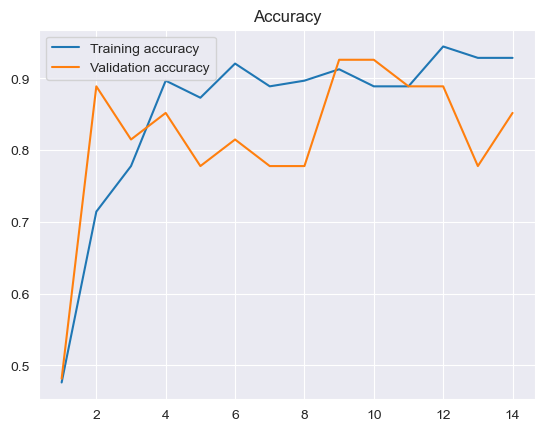

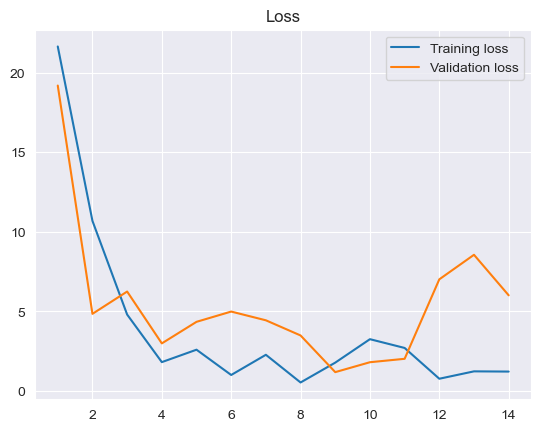

In [8]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = list(range(1, len(accuracy)+1))

plt.plot(epochs, accuracy, label="Training accuracy")
plt.plot(epochs, val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Accuracy")
plt.figure()
plt.plot(epochs, loss, label="Training loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.legend()
plt.title("Loss")
plt.show()


Avataan lukitus VGG16:n ylimmistä konvoluutiokerroksista ja hienosäädetään niiden koulutusta yhdessä oman luokittelukerroksen kanssa.

1. Sulatetaan VGG16:n yläkerroksia
- conv_base.trainable = True: Aiemmin VGG16:n konvoluutiokerrokset olivat lukittuja (ei opetettu), mutta nyt sulatat koko konvoluutiopohjan.
2. Lukitaan osat VGG16:sta
- Tässä lukitaan kaikki kerrokset paitsi viimeiset neljä kerrosta.
3. Kompilointi hienosäätöä varten
- optimizer=RMSprop(learning_rate=1e-5): Käytetään RMSpropia, joka on hyvä optimoija hienosäädölle, ja asetetaan erittäin pieni oppimisnopeus (1e-5), koska nyt opetetaan vain osittain konvoluutiokerroksia.

- loss="sparse_categorical_crossentropy"
→ sparse_categorical_crossentropy on edelleen oikea valinta, koska käytät kokonaislukuja luokittelussa.

In [9]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False
    
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
    metrics=["accuracy"]
)

Mallin hienosäätö (Fine-Tuning) ja parhaiden painojen tallentaminen.

In [10]:

callbacks = [
    EarlyStopping(
        patience=5,
        verbose=1,
        restore_best_weights=True,
        monitor="val_loss"
    ),
    ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss",
        verbose=1
    )
]

start_time = time.time()
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks
)

training_time = time.time() - start_time

test_loss, test_acc = model.evaluate(test_dataset)

# Save results
np.savez("VGG_FineTuned_kuvantunnistus_results.npz",
         test_acc=test_acc,
         test_loss=test_loss,
         training_time=training_time,
         history=history.history)



Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.9048 - loss: 1.7825
Epoch 1: val_loss improved from inf to 0.41877, saving model to fine_tuning.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 403ms/step - accuracy: 0.9062 - loss: 1.7593 - val_accuracy: 0.9259 - val_loss: 0.4188
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.9797 - loss: 1.2068
Epoch 2: val_loss did not improve from 0.41877
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 397ms/step - accuracy: 0.9796 - loss: 1.2107 - val_accuracy: 0.9259 - val_loss: 0.7803
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.9647 - loss: 0.4569
Epoch 3: val_loss did not improve from 0.41877
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 400ms/step - accuracy: 0.9646 - loss: 0.4577 - val_accuracy: 0.9630 - val_loss: 0.6767
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.9685 - loss: 0.4669
Epoch 4: val_loss did not improve from 0.41877
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 404ms/step - accuracy: 0.9683 - loss: 0.4780 - v

Lataa mallin, joka on tallennettu parhailla painoilla validointihäviön perusteella.Tulosta.

In [11]:
test_model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:3f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Test accuracy: 1.000000


## Vertailu
Analysoi eroja CNN ja Esikoulutettu malli piirteenirrottajana malleihin.

### Malli 1: Perus-CNN (rakennettu alusta)
Arkkitehtuuri: 3 konvoluutiokerrosta + Dense
- Dropout: Kyllä (0.5)
- Tulos (Test Accuracy): 0.519

Malli oppii huonosti, mahdollisesti liian yksinkertainen tai ei riittävästi dataa.

### Malli 2: Feature Extraction VGG16 (etukäteen laskettuna)
- Arkkitehtuuri: Esikoulutettu VGG16 (ilman yläkerroksia), ominaisuudet etukäteen laskettu
- Tulos (Test Accuracy): 0.815

Merkittävä parannus Malliin 1 verrattuna. Nopeampi koulutus (ominaisuudet esilasketaan).

Ei hienosäätöä (conv_base on täysin jäädytetty). Malli ei opi uusia piirteitä datasta – jäädytetyt painot rajoittavat hienovaraista oppimista.

### Malli 3: Transfer Learning + Fine-Tuning (VGG16)
- Arkkitehtuuri: VGG16 (feature extractor), Dense + Dropout
- Alkuun: conv_base jäädytetty → accuracy: 0.851
- Hienosäätö (fine-tuning): Viimeiset 4 kerrosta avattu, optimizer vaihdettu RMSprop (LR=1e-5)
- → Final Test Accuracy: 1.000

Selkeästi paras tulos.
Hienosäätö mahdollistaa tarkemman mukautumisen datasettiin.
Yleinen strategia parhaiden tulosten saavuttamiseen kuvien luokittelussa.

###  Yhteenveto

| Malli | Strategia | Test Accuracy |
|-------|-----------|---------------|
| 1     | Perus CNN | 0.519         |
| 2     | Feature extraction (VGG16) | 0.815         |
| 3     | Transfer learning + fine-tuning | **1.000**     |
